Date                             datetime64[ns]
Closeprice                              float64
WeightedAVG                             float64
TitleNegative                           float64
TitleNeutral                            float64
TitlePositive                           float64
TitleCompound                           float64
TextNegative                            float64
TextNeutral                             float64
TextPositive                            float64
TextCompound                            float64
TransactionVolume                       float64
EthSpentOverTime                        float64
SocialVolumeReddit                      float64
GasUsed                                 float64
SentimentPosReddit                      float64
SentimentNegReddit                      float64
SentimentBalanceReddit                  float64
SentimentVolumeConsumedReddit           float64
SocialDomReddit                         float64
DailyAddresses                          

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_40 (Masking)        (None, 8, 21)             0         
                                                                 
 lstm_40 (LSTM)              (None, 50)                14400     
                                                                 
 dense_40 (Dense)            (None, 1)                 51        
                                                                 
Total params: 14,451
Trainable params: 14,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
26/26 - 6s - loss: 0.1003 - val_loss: 0.0797 - 6s/epoch - 237ms/step
Epoch 2/50
26/26 - 0s - loss: 0.0580 - val_loss: 0.0382 - 248ms/epoch - 10ms/step
Epoch 3/50
26/26 - 0s - loss: 0.0467 - val_loss: 0.0299 - 257ms/epoch - 10ms/step
Epoch 4/50
26/26 - 0s - loss: 0.0442 - val_loss: 0.0334 - 272ms/epoch

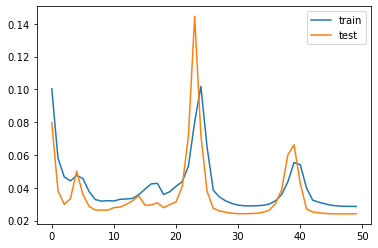

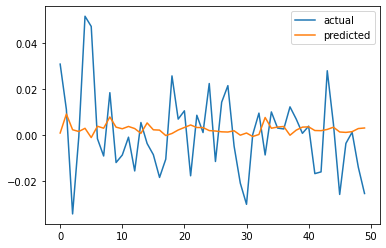

Test RMSE: 0.015


In [73]:
# from LSTMobject import LSTM
import scipy
import numpy
from numpy import sqrt
from matplotlib import pyplot
from numpy import concatenate
import pandas as pd
import statsmodels
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
dataset = pd.read_csv(r'/Users/JMSaadon/PycharmProjects/PycharmRedditSentimentAnalysis/FullData.csv', usecols=['Date', 'WeightedAVG', 'TitleNegative', 'TitleNeutral', 'TitlePositive', 'TitleCompound', 'TextNegative', 'TextNeutral', 'TextPositive', 'TextCompound', 'Closeprice', 'TransactionVolume', 'EthSpentOverTime', 'SocialVolumeReddit', 'GasUsed', 'SentimentPosReddit', 'SentimentNegReddit', 'SentimentBalanceReddit', 'SentimentVolumeConsumedReddit', 'SocialDomReddit', 'DailyAddresses'])
# print(dataset.columns)
dataset = dataset[['Date', 'Closeprice', 'WeightedAVG', 'TitleNegative', 'TitleNeutral', 'TitlePositive', 'TitleCompound', 'TextNegative', 'TextNeutral', 'TextPositive', 'TextCompound', 'TransactionVolume', 'EthSpentOverTime', 'SocialVolumeReddit', 'GasUsed', 'SentimentPosReddit', 'SentimentNegReddit', 'SentimentBalanceReddit', 'SentimentVolumeConsumedReddit', 'SocialDomReddit', 'DailyAddresses']]
dataset['Date'] = pd.to_datetime(dataset['Date'])
print(dataset.dtypes)
Returns = [0]
dataset.sort_values(by='Date', inplace=True)
dataset.set_index('Date', inplace=True)
for i in range(1, len(dataset['Closeprice'])):
    Returns.append((dataset['Closeprice'][i] / dataset['Closeprice'][i-1]) - 1)
dataset['Returns'] = Returns
dataset = dataset[[ 'Returns', 'Closeprice', 'WeightedAVG', 'TitleNegative', 'TitleNeutral', 'TitlePositive', 'TitleCompound', 'TextNegative', 'TextNeutral', 'TextPositive', 'TextCompound', 'TransactionVolume', 'EthSpentOverTime', 'SocialVolumeReddit', 'GasUsed', 'SentimentPosReddit', 'SentimentNegReddit', 'SentimentBalanceReddit', 'SentimentVolumeConsumedReddit', 'SocialDomReddit', 'DailyAddresses']]

print(dataset)
values = dataset.values


def series_to_supervised(data, n_in=1, n_out=1, dropnan=False):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    agg.fillna(-1, inplace=True)
    return agg

# specify the number of lag hours
n_3hrSets = 8
n_features = 21
# # ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled[0])
# frame as supervised learning
reframed = series_to_supervised(scaled, n_3hrSets, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]], axis=1, inplace=True)
# reframed.drop(0, axis=0, inplace=True)
print(reframed.head())
for i in reframed.columns:
    print(i)
values = reframed.values
# print(values[0:2])
# print(values.shape)
# print("THIS: values[:, -1] PRINTS:  ")
# print(values[:, -1])

n_trainandvalid_hours = int(len(values)*0.8)
trainandvalid = values[:n_trainandvalid_hours, :]
n_train_hours = int(len(trainandvalid)*0.8)
train = values[:n_train_hours, :]
valid = values[n_train_hours:, :]
test = values[n_trainandvalid_hours:, :]

# n_train_hours = int(len(values)*0.8)
# # n_train_hours = 365 * 24
# train = values[:n_train_hours, :]
# print("train and test shapes")
# print(train.shape)
# test = values[n_train_hours:, :]
# print(test.shape)

# split into input and outputs
n_obs = n_3hrSets * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
valid_X, valid_y = valid[:, :n_obs], valid[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
print("train and test inputs and outputs")
print(train_X.shape)
print(train_y.shape)
print(train_y)
print(test_X.shape)
print(test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_3hrSets, n_features))
valid_X = valid_X.reshape((valid_X.shape[0], n_3hrSets, n_features))
test_X = test_X.reshape((test_X.shape[0], n_3hrSets, n_features))
# print(train_X[0])
# print("What is test_X")
# print(test_X[:, 1:])
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# # print(train_X.shape[1])
# # print(train_X.shape[2])
# design network
model = Sequential()
model.add(Masking(mask_value=-1, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(valid_X, valid_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_3hrSets*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -20:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -20:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

pyplot.plot(inv_y[-50:], label='actual')
pyplot.plot(inv_yhat[-50:], label='predicted')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [74]:
bothUp = 0
bothDown = 0
falseUp = 0 
falseDown = 0
counter = 0
# print(inv_yhat)
# print(len(inv_yhat))
for i in range(1, len(inv_yhat)):
    if (inv_yhat[i] > inv_y[i-1]) and (inv_y[i] > inv_y[i-1]):
        bothUp = bothUp + 1
    elif (inv_yhat[i] < inv_y[i-1]) and (inv_y[i] < inv_y[i-1]):
        bothDown = bothDown + 1
    elif (inv_yhat[i] > inv_y[i-1]) and (inv_y[i] < inv_y[i-1]):
        falseUp = falseUp + 1
    elif (inv_yhat[i] < inv_y[i-1]) and (inv_y[i] > inv_y[i-1]):
        falseDown = falseDown + 1
    else:
        counter = counter + 1
        print(counter)
print("bothUp: ")
print(bothUp)
print("bothDown: ")
print(bothDown)
print("falseUp")
print(falseUp)
print("falseDown")
print(falseDown)

SuccessRate = (bothUp+bothDown)/(bothUp+bothDown+falseDown+falseUp) * 100
print(SuccessRate)

1
bothUp: 
238
bothDown: 
202
falseUp
84
falseDown
59
75.47169811320755


In [13]:
# pyplot.plot(inv_y[-50:], label='actual')
# pyplot.plot((inv_y[-50:] - inv_yhat[-50:]), label='resid')
# pyplot.plot(inv_yhat[-50:], label='pred')
#dont connect graph
print(inv_y.shape)
# pyplot.legend()
# pyplot.scatter(x, inv_y[-50:] - inv_yhat[-50:])

(585,)


In [15]:
print(test_X)

[[ 0.5102994   0.29475307  0.6517375  ...  0.3900103   0.24136506
  -1.        ]
 [ 0.5407852   0.3018055   0.5169125  ...  0.57357305  0.23878491
  -1.        ]
 [ 0.5177781   0.30017716  0.5798634  ...  0.71335053  0.27847221
  -1.        ]
 ...
 [ 0.52368945  0.11601937  0.47233155 ...  0.5872855   0.15995419
  -1.        ]
 [ 0.5307258   0.11859429  0.4544368  ...  0.48999098  0.10350854
  -1.        ]
 [ 0.48410654  0.10726601  0.6106214  ...  0.43116084  0.1705018
  -1.        ]]


In [19]:
test_dates = dataset.index[n_trainandvalid_hours:]
print(test_dates)

DatetimeIndex(['2022-03-06 15:00:00', '2022-03-06 18:00:00',
               '2022-03-06 21:00:00', '2022-03-07 00:00:00',
               '2022-03-07 03:00:00', '2022-03-07 06:00:00',
               '2022-03-07 09:00:00', '2022-03-07 12:00:00',
               '2022-03-07 15:00:00', '2022-03-07 18:00:00',
               ...
               '2022-05-17 12:00:00', '2022-05-17 15:00:00',
               '2022-05-17 18:00:00', '2022-05-17 21:00:00',
               '2022-05-18 00:00:00', '2022-05-18 03:00:00',
               '2022-05-18 06:00:00', '2022-05-18 09:00:00',
               '2022-05-18 12:00:00', '2022-05-18 15:00:00'],
              dtype='datetime64[ns]', name='Date', length=585, freq=None)


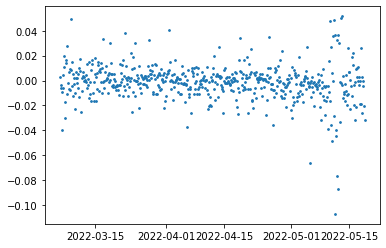

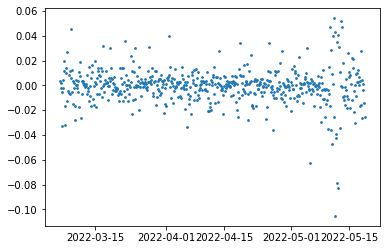

In [24]:
pyplot.scatter(test_dates, inv_y - inv_yhat, s=(3))
pyplot.show()
pyplot.scatter(test_dates, inv_y, s=(3))
pyplot.show()
# pyplot.savefig('.pdf')

In [80]:
import csv
# data = [test_dates[i], inv_y[i], inv_yhat[i]]
with open('Predictions.csv', 'w', encoding='UTF8', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Date", "Actual", "Predicted"])
    for i in range(len(test_dates)):
        writer.writerow([test_dates[i], inv_y[i], inv_yhat[i]])

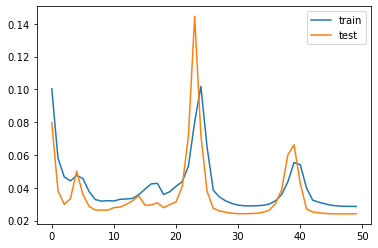

In [81]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [87]:
epochnums = list(range(50))
print(len(epochnums))
with open('TrainandTest.csv', 'w', encoding='UTF8', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train", "Test"])
    for i in range(len(epochnums)):
        writer.writerow([epochnums[i], history.history['loss'][i], history.history['val_loss'][i]])

50
